### École Polytechnique de Montréal <br> Département Génie Informatique et Génie Logiciel <br>  INF8460 – Traitement automatique de la langue naturelle <br> 
# <center> TP2 INF8460 <br>  Automne 2021 </center>

## 1. DESCRIPTION
Le but de ce TP est de comparer différents classificateurs que vous allez entraîner à reconnaitre le genre (masculin, féminin) d'un blogueur.

## 2. LIBRAIRIES PERMISES
- Jupyter notebook
- NLTK
- Numpy 
- Pandas
- Sklearn
- Keras

Pour toute autre librairie, demandez à votre chargé de laboratoire via le forum du cours sur Moodle.

## 3. INFRASTRUCTURE

- Vous avez accès aux GPU du local L-4818. Dans ce cas, vous devez utiliser le dossier temp (voir le tutoriel VirtualEnv.pdf)
- Vous pouvez aussi utiliser l’environnement Google Colab: https://colab.research.google.com/

## 4. DESCRIPTION DES DONNEES

Plusieurs fichiers au format csv sont disponibles et sont extraits de blogs échangés sur Blogger.com. Les données sont disponibles dans le répertoire data. 

Elles ont la forme suivante:
- Train: contient 7 000 exemples de blogs écrits par des hommes et des femmes
- Val: contient 1 000 exemples
- Test: contient 2 000 exemples

## 5. ETAPES DU TP 
À partir du présent notebook inf8460_A21_TP2, vous devez réaliser les étapes suivantes. (Noter que les cellules sont là à titre informatif, il est fort probable que vous rajoutiez des sections au fur et à mesure de votre TP).

Ci-dessous définir la constante _PATH_ qui doit être utilisée par votre code pour accéder aux fichiers. Il est attendu que pour la correction, le chargé de lab n'ait qu'à changer la valeur de _PATH_ pour le répertoire où se trouver les fichiers de datasets.

In [1]:
#PATH = "drive/MyDrive/TPS/TP2"
PATH = "drive/MyDrive/POLY/INF8460/TPS/TP2"

In [2]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir(PATH)

Mounted at /content/drive


#### importation des librairies pour les modèles traditionnelles

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
#from sklearn import ...

#### importation des librairies pour les modèles de machine learning

In [4]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import OneHotEncoder
from keras.utils import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.layers import Embedding
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model

import codecs
from tqdm import tqdm
import gensim

import string

In [5]:
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

### 5.1. prétraitement et description des données (10%)

1. (4 points) Effectuez le pré-traitement suivant sur le champ *text*: convertir le texte en minuscules, supprimer les stopwords et gardez les signes de ponctuation.

In [6]:
train_data = pd.read_csv("train.csv")
train_data

,id,gender,topic,text
0,883178,male,Fashion,I Think I'm Going to Hyperventilat...
1,1103575,female,indUnk,I blogged out on xanga... silly Rachel....
2,4192173,male,Technology,Literally. As I type this at 4:40...
3,883178,male,Fashion,Don't Buy a Skirt on Sale So I g...
4,649790,female,indUnk,New Silly Song ahead... The sun...
...,...,...,...,...
6995,589736,male,Technology,"ben, where did you find that wacko ..."
6996,1103575,female,indUnk,that's amazing. spring break this week....
6997,2844168,female,Marketing,When I was in elementary scho...
6998,883178,male,Fashion,I had to change my cell phone numb...


In [7]:
val_data = pd.read_csv("valid.csv")
test_data = pd.read_csv("test.csv")

In [8]:
# Conversion en minuscules
def lower_case(data):
  liste_lower = []
  for word in data:
    liste_lower.append(word.lower())
  return liste_lower

# Segmentation
def segm(data):
  return nltk.word_tokenize(data)

# Suppression des stopwords
def rm_stopwords(segm_data):
  stopwords_english = stopwords.words('english')
  data_cleaned = []
  for word in segm_data:
    if (word not in stopwords_english ): # mots fréquents qui montre un sentiment "!",'...','?'
        data_cleaned.append(word)
  return data_cleaned

# Lemmatisation
def lemmatize(corpus):
  lemmzer = nltk.WordNetLemmatizer()
  return [lemmzer.lemmatize(token) for token in corpus]

In [9]:
# Application du prétraitement sur les paragraphes et les questions

def preprocess(df, index):
  df["pre_tokens"] = df[index].apply(nltk.word_tokenize)
  df['lower_case'] = df['pre_tokens'].apply(lower_case)
  df['tokens'] = df['lower_case'].apply(rm_stopwords)
  #df['tokens'] = df['no_stopwords'].apply(lemmatize)
  df['text_final'] = df['tokens'].apply(' '.join)
  return df

In [10]:
train_data = preprocess(train_data, "text")
val_data = preprocess(val_data, "text")
test_data = preprocess(test_data, "text")

2. (3 points) Calculez les statistiques suivantes: Nombre total de types; Nombre total de types/genre; top 20 des types les plus fréquents par genre (male/female).

In [11]:
# Fonction utile pour transformer une liste de sous listes en une seule liste contenant tout les items de ces sous listes
def flatten(t):
    return [item for sublist in t for item in sublist]

# Fonction pour afficher les clefs les plus fréquentes d'un dictionnaire de fréquence
def most_frequent(dic, N):
  return [elt[0] for elt in sorted(males_types.items(), key=lambda x: x[1])][-N:]

In [12]:
vocab_size = len(set(flatten(train_data['tokens'])))
print("Nb type:", vocab_size)
males_types = FreqDist(flatten(train_data[train_data["gender"] == "male"]['tokens']))
females_types = FreqDist(flatten(train_data[train_data["gender"] == "female"]['tokens']))
print(f"Nb type male: {len(males_types.keys())} / Nb type female: {len(females_types.keys())}")
print(f"Most frequent types for males : {most_frequent(males_types, 20)}")
print(f"Most frequent types for males : {most_frequent(females_types, 20)}")

Nb type: 54164
Nb type male: 36574 / Nb type female: 33125
Most frequent types for males : ['&', 'time', 'get', 'would', '-', ';', "'m", 'one', 'like', ':', "n't", '!', "'", '(', '?', '...', ')', "'s", ',', '.']
Most frequent types for males : ['&', 'time', 'get', 'would', '-', ';', "'m", 'one', 'like', ':', "n't", '!', "'", '(', '?', '...', ')', "'s", ',', '.']


3. (3 points) Dans deux figures séparées, affichez la distribution des sujets (topics) en termes de fréquence pour les hommes (male) et les femmes (female).

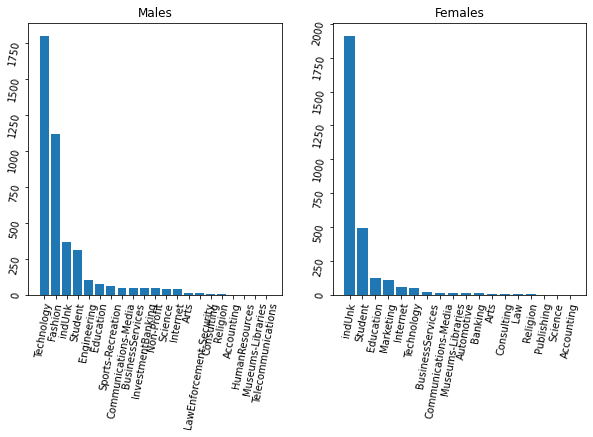

In [13]:
topics_males = sorted(FreqDist(train_data[train_data["gender"] == "male"]['topic'].values).items(), key=lambda x: x[1], reverse=True)
topics_female = sorted(FreqDist(train_data[train_data["gender"] == "female"]['topic'].values).items(), key=lambda x: x[1], reverse=True)
f, axes = plt.subplots(1,2)
X, Y = zip(*topics_males)
axes[0].set_title('Males')
axes[0].bar(X, Y)
axes[0].tick_params(labelrotation=80)
X, Y = zip(*topics_female)
axes[1].set_title('Females')
axes[1].bar(X, Y)
axes[1].tick_params(labelrotation=80)
f.set_size_inches(10,5)
plt.show()

### 5.2. Classification traditionnelle à base de textes (35%)

1. (10 points) Implémentez un classificateur Naïve Bayes et de régression logistique avec sklearn se basant sur un modèle sac de mots unigrame du contenu des blogues, pondéré avec TF-IDF.

In [ ]:
train_part1 = pd.concat([train_data, val_data])
train_part1

,id,gender,topic,text,pre_tokens,lower_case,tokens,text_final
0,883178,male,Fashion,I Think I'm Going to Hyperventilat...,"[I, Think, I, 'm, Going, to, Hyperventilate, I...","[i, think, i, 'm, going, to, hyperventilate, i...","[think, 'm, going, hyperventilate, found, tick...",think 'm going hyperventilate found tickets go...
1,1103575,female,indUnk,I blogged out on xanga... silly Rachel....,"[I, blogged, out, on, xanga, ..., silly, Rache...","[i, blogged, out, on, xanga, ..., silly, rache...","[blogged, xanga, ..., silly, rachel, .]",blogged xanga ... silly rachel .
2,4192173,male,Technology,Literally. As I type this at 4:40...,"[Literally, ., As, I, type, this, at, 4:40, a....","[literally, ., as, i, type, this, at, 4:40, a....","[literally, ., type, 4:40, a.m., tuesday, ,, b...","literally . type 4:40 a.m. tuesday , burning d..."
3,883178,male,Fashion,Don't Buy a Skirt on Sale So I g...,"[Do, n't, Buy, a, Skirt, on, Sale, So, I, go, ...","[do, n't, buy, a, skirt, on, sale, so, i, go, ...","[n't, buy, skirt, sale, go, urllink, anthropol...","n't buy skirt sale go urllink anthropologie , ..."
4,649790,female,indUnk,New Silly Song ahead... The sun...,"[New, Silly, Song, ahead, ..., The, sun, 's, s...","[new, silly, song, ahead, ..., the, sun, 's, s...","[new, silly, song, ahead, ..., sun, 's, shing,...",new silly song ahead ... sun 's shing outside ...
...,...,...,...,...,...,...,...,...
995,589736,male,Technology,what's wrong angie?,"[what, 's, wrong, angie, ?]","[what, 's, wrong, angie, ?]","['s, wrong, angie, ?]",'s wrong angie ?
996,589736,male,Technology,Once the party discovers what happened to C...,"[Once, the, party, discovers, what, happened, ...","[once, the, party, discovers, what, happened, ...","[party, discovers, happened, castillion, (, my...",party discovers happened castillion ( mystery ...
997,589736,male,Technology,Thanks to The Powers That Be for se...,"[Thanks, to, The, Powers, That, Be, for, sendi...","[thanks, to, the, powers, that, be, for, sendi...","[thanks, powers, sending, johnathan, take, car...",thanks powers sending johnathan take care 'm h...
998,766556,female,indUnk,"Munday again Well, I survived the wee...","[Munday, again, Well, ,, I, survived, the, wee...","[munday, again, well, ,, i, survived, the, wee...","[munday, well, ,, survived, weekend, 4, year, ...","munday well , survived weekend 4 year old diva..."


In [ ]:
#defining our targets
y_test_part1 = test_data["gender"].apply(["male", "female"].index).values
y_train_part1 = train_part1["gender"].apply(["male", "female"].index).values

In [ ]:
# TFIDF unigram
vectorizer = TfidfVectorizer(max_features=5000)
tfidf = vectorizer.fit_transform(train_part1['text_final'].values)

# x_train unigram tfidf
X_train1_part1 = tfidf.toarray()

In [ ]:
# naive modele on unigram
gnb1 = MultinomialNB()
gnb1.fit(X_train1_part1, y_train_part1)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
# logistic regression modele on unigram
lr1 = LogisticRegression()
lr1.fit(X_train1_part1, y_train_part1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

2. (10 points) Implémentez un classificateur Naïve Bayes et de régression logistique avec sklearn se basant sur un modèle sac de mots unigrame **et** bigramme du contenu des blogues, pondéré avec TF-IDF.

In [ ]:
# TFIDF bigram
vectorizer12 = TfidfVectorizer(ngram_range=(1,2), max_features=5000)
tfidf12 = vectorizer12.fit_transform(train_part1['text_final'].values)

# x_train bigram tfidf
X_train2_part1 = tfidf12.toarray()

In [ ]:
# naive modele on bigram
gnb2 = MultinomialNB()
gnb2.fit(X_train2_part1, y_train_part1)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
# logistic regression on bigram
lr2 = LogisticRegression()
lr2.fit(X_train2_part1, y_train_part1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

3. (5 points) Testez vos deux modèles et retournez les valeurs des métriques d’évaluation: précision globale (accuracy) et précision, rappel et F1-score par classe. Affichez aussi les macro moyennes pour toutes ces métriques.

In [ ]:
# tfidf on test set
X_test1_part1 = vectorizer.transform(test_data["text_final"]).toarray() #unigram
X_test2_part1 = vectorizer12.transform(test_data["text_final"]).toarray()#biigram

# prediction of naive bayes modele on both unigram and bigram test set
y_pred1_part1 = gnb1.predict(X_test1_part1)
y_pred2_part1 = gnb2.predict(X_test2_part1)

# prediction of logistic regression modele on both unigram and bigram test set
y_pred3_part1 = lr1.predict(X_test1_part1)
y_pred4_part1 = lr2.predict(X_test2_part1)

In [ ]:
C1 = confusion_matrix(y_pred1_part1, y_test_part1)
C2 = confusion_matrix(y_pred2_part1, y_test_part1)
C3 = confusion_matrix(y_pred3_part1, y_test_part1)
C4 = confusion_matrix(y_pred4_part1, y_test_part1)
print("Confusion matrix naive bayes for unigrams:", C1, sep="\n")
print("Confusion matrix naive bayes for unigrams and bigrams:", C2, sep="\n")
print("Confusion matrix logistic regression for unigrams:", C3, sep="\n")
print("Confusion matrix logistic regression for unigrams and bigrams:", C4, sep="\n")

Confusion matrix naive bayes for unigrams:
[[1040  302]
 [ 132  526]]
Confusion matrix naive bayes for unigrams and bigrams:
[[1035  306]
 [ 137  522]]
Confusion matrix logistic regression for unigrams:
[[1047  285]
 [ 125  543]]
Confusion matrix logistic regression for unigrams and bigrams:
[[1039  296]
 [ 133  532]]


In [ ]:
print("naive bayes for unigrams")
print(classification_report(y_test_part1, y_pred1_part1))

naive bayes for unigrams
              precision    recall  f1-score   support

           0       0.77      0.89      0.83      1172
           1       0.80      0.64      0.71       828

    accuracy                           0.78      2000
   macro avg       0.79      0.76      0.77      2000
weighted avg       0.79      0.78      0.78      2000



In [ ]:
print("naive bayes for unigrams and bigrams")
print(classification_report(y_test_part1, y_pred2_part1))

naive bayes for unigrams and bigrams
              precision    recall  f1-score   support

           0       0.77      0.88      0.82      1172
           1       0.79      0.63      0.70       828

    accuracy                           0.78      2000
   macro avg       0.78      0.76      0.76      2000
weighted avg       0.78      0.78      0.77      2000



In [ ]:
print("logistic regression for unigrams")
print(classification_report(y_test_part1, y_pred3_part1))

logistic regression for unigrams
              precision    recall  f1-score   support

           0       0.79      0.89      0.84      1172
           1       0.81      0.66      0.73       828

    accuracy                           0.80      2000
   macro avg       0.80      0.77      0.78      2000
weighted avg       0.80      0.80      0.79      2000



In [ ]:
print("logistic regression for unigrams and bigrams")
print(classification_report(y_test_part1, y_pred4_part1))

logistic regression for unigrams and bigrams
              precision    recall  f1-score   support

           0       0.78      0.89      0.83      1172
           1       0.80      0.64      0.71       828

    accuracy                           0.79      2000
   macro avg       0.79      0.76      0.77      2000
weighted avg       0.79      0.79      0.78      2000



4. (10 points) Trouvez les paramètres optimaux en utilisant un pipeline et GridSearch. Retournez la configuration optimale et sa performance pour chaque algorithme (Naive Bayes, Régression logistique) avec cette configuration en testant les paramètres suivants: 
- Modèle basé sur les mots ou les caractères
- Type de n-gramme (1, 2 et leur combinaison) 
- Utilisation ou non de TF-IDF
- Minuscule avec TF-IDF ou non
- Taille du vocabulaire: 5000, 10000, none
- Pour Naive Bayes, testez différentes valeurs du paramètre alpha (bayes__alpha)
- Pour la régression logistique, testez aussi différentes stratégies de régularisation (logistic_penalty)

In [ ]:
# pipeline definition
clf_nb = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

# parameters
parameters_nb = {
    'vect__analyzer': ["word", "char"],
    'vect__ngram_range': [(1, 1), (2, 2), (1, 2)],
    'vect__lowercase': (True,False),
    'vect__max_features': (5000,10000, None),
    'tfidf__use_idf': (True, False),
    'clf__alpha': (1e-1, 5e-2, 1e-2, 1e-3, 1e-4)
}

In [ ]:
# Gridsearch for the naive bayes modele
gs_clf_nb = GridSearchCV(clf_nb, parameters_nb, n_jobs=-1, verbose=10)
gs_clf_nb.fit(train_part1["text"], y_train_part1)
y_pred_nb = gs_clf_nb.predict(test_data["text"])

print("Meilleurs paramètres trouvés:\n", gs_clf_nb.best_params_, "\n")
print("Meilleur score atteint:\n", gs_clf_nb.best_score_, "\n")

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  6

Meilleurs paramètres trouvés:
 {'clf__alpha': 0.1, 'tfidf__use_idf': True, 'vect__analyzer': 'word', 'vect__lowercase': False, 'vect__max_features': None, 'vect__ngram_range': (1, 1)} 

Meilleur score atteint:
 0.8133750000000001 



In [ ]:
"""
Meilleurs paramètres trouvés:
 {'clf__alpha': 0.1, 'tfidf__use_idf': True, 'vect__analyzer': 'word', 'vect__lowercase': False, 'vect__max_features': None, 'vect__ngram_range': (1, 1)} 
Meilleur score atteint:
 0.8133750000000001
"""

"\nMeilleurs paramètres trouvés:\n {'clf__alpha': 0.1, 'tfidf__use_idf': True, 'vect__analyzer': 'word', 'vect__lowercase': False, 'vect__max_features': None, 'vect__ngram_range': (1, 1)} \nMeilleur score atteint:\n 0.8133750000000001\n"

In [ ]:
print("naive bayes for unigrams")
print(classification_report(y_test_part1, y_pred_nb))

naive bayes for unigrams
              precision    recall  f1-score   support

           0       0.81      0.88      0.85      1172
           1       0.81      0.71      0.76       828

    accuracy                           0.81      2000
   macro avg       0.81      0.80      0.80      2000
weighted avg       0.81      0.81      0.81      2000



In [ ]:
clf_lr = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression()),
])

parameters_lr = {
    'vect__analyzer': ["word", "char"],
    'vect__ngram_range': [(1, 1), (2, 2), (1, 2)],
    'vect__lowercase': (True,False),
    'vect__max_features': (5000,10000, None),
    'tfidf__use_idf': (True, False),
    'clf__penalty': (None, "l1", "l2", "elasticnet")
}

In [ ]:
# Gridsearch for the logistic regression modele
gs_clf_lr = GridSearchCV(clf_lr, parameters_lr, n_jobs=-1, verbose=10)
gs_clf_lr.fit(train_part1["text"], y_train_part1)
y_pred_lr = gs_clf_lr.predict(test_data["text"])

print("Meilleurs paramètres trouvés:\n", gs_clf_lr.best_params_, "\n")
print("Meilleur score atteint:\n", gs_clf_lr.best_score_, "\n")

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  5

Meilleurs paramètres trouvés:
 {'clf__penalty': 'l2', 'tfidf__use_idf': True, 'vect__analyzer': 'word', 'vect__lowercase': True, 'vect__max_features': None, 'vect__ngram_range': (1, 1)} 

Meilleur score atteint:
 0.7875 



In [ ]:
"""
Meilleurs paramètres trouvés:
 {'clf__penalty': 'l2', 'tfidf__use_idf': True, 'vect__analyzer': 'word', 'vect__lowercase': True, 'vect__max_features': None, 'vect__ngram_range': (1, 1)} 

Meilleur score atteint:
 0.7875
"""

"\nMeilleurs paramètres trouvés:\n {'clf__penalty': 'l2', 'tfidf__use_idf': True, 'vect__analyzer': 'word', 'vect__lowercase': True, 'vect__max_features': None, 'vect__ngram_range': (1, 1)} \n\nMeilleur score atteint:\n 0.7875\n"

In [ ]:
print(classification_report(y_test_part1, y_pred_lr))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83      1172
           1       0.81      0.65      0.72       828

    accuracy                           0.79      2000
   macro avg       0.79      0.77      0.78      2000
weighted avg       0.79      0.79      0.79      2000



### 5.3. Classification neuronale (45%)

#### BiLSTM sans plongement pré-entrainé

1. (10 points) Implémentez un modèle à deux couches Bi-LSTM avec Keras sans plongements pré-entrainés et entrainez-le sur l’ensemble d’entrainement (voir les points suivants). Assurez-vous que votre séquence maximale prenne en compte la plus longue séquence de votre ensemble de données d’entrainement.

##### Preprocessing pour la classification neuronale

In [17]:
# we first convert the labels to numerical numbers
female_label, male_label = 1, 0
target_conversion = {
    'female': female_label,
    'male': male_label
}

train_data['target'] = train_data['gender'].map(target_conversion)
val_data['target'] = val_data['gender'].map(target_conversion)
test_data['target'] = test_data['gender'].map(target_conversion)

#we define our train and validation set
x_train = train_data['tokens']
y_train = train_data['target']
x_val = val_data['tokens']
y_val = val_data['target']
x_test = test_data['tokens']
y_test = test_data['target']

In [18]:
def corpus_tokenize(corpus,tokenizer, max_seq_len):
    sequences = tokenizer.texts_to_sequences(corpus)
    # pad the vectors to have the same length (here it is the maximal length )
    text = pad_sequences(sequences, maxlen=max_seq_len)
    return text

In [19]:
#preprocessing by tokenizing the corpus and padding the vectors
nb_features = 20000 #20% du vocabulaire d'après la loi de zipf
nb_words = np.min([nb_features, vocab_size])
max_seq_len = np.max([len(x) for x in x_train]) #the sequence maximal size

tokenizer = Tokenizer(num_words=nb_words)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

x_train_tokenized = corpus_tokenize(x_train, tokenizer, max_seq_len)
x_val_tokenized = corpus_tokenize(x_val, tokenizer, max_seq_len)
x_test_tokenized = corpus_tokenize(x_test, tokenizer, max_seq_len)

##### Création et entrainement du modèle

In [ ]:
# Bi-LSTM model in Keras.
def bi_lstm_model(max_seq_len,
                  vocab_size,
                  lstm_units,
                  dropout_rate,
                  embeded_dim,
                  drop_bool=False): #boolean to use dropout or not
  
    # define the layers.
    inputs = keras.Input(shape=(max_seq_len,), dtype="int32")

    x = layers.Embedding(vocab_size, embeded_dim)(inputs)
    x = layers.Bidirectional(layers.LSTM(units=lstm_units, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(units=lstm_units))(x)
    if (drop_bool==True):
      x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
## TUNING PARAMETERS ##
#max_seq_len
#nb_words
lstm_units = 64
dropout_rate = 0.2
embeded_dim = 100 # value usually between 100 et 300
drop_bool = False

model_bi_lstm_1 = bi_lstm_model(max_seq_len, nb_words, lstm_units, dropout_rate, embeded_dim,drop_bool=drop_bool)

# compile the model
model_bi_lstm_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #,'AUC'
# summarize the model
print(model_bi_lstm_1.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5780)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 5780, 100)         2000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 5780, 128)         84480     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,183,425
Trainable params: 2,183,425
Non-trainable params: 0
_________________________________________________________________
None


2. (2 points) Effectuez un «EarlyStopping» prenant en compte une «val_loss» minimale et en attendant 3 époques.

3. (2 points) En utilisant un ModelCheckpoint, sauvegardez votre meilleur modèle pour lequel la métrique «val_accuracy» soit maximale.

In [ ]:
#defining the checkpoint
checkpoint1 = ModelCheckpoint("best_model_no_emb.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
callback1 = EarlyStopping(monitor='val_loss', patience=3)

historic_bilstm_1 = model_bi_lstm_1.fit(x_train_tokenized, y_train, batch_size=32, epochs=6, validation_data=(x_val_tokenized, y_val), callbacks=[checkpoint1,callback1])
          

Epoch 1/6
219/219 [==============================] - 513s 2s/step - loss: 0.5698 - accuracy: 0.7064 - val_loss: 0.4925 - val_accuracy: 0.7720

Epoch 00001: val_accuracy improved from -inf to 0.77200, saving model to best_model_no_emb.hdf5
Epoch 2/6
219/219 [==============================] - 505s 2s/step - loss: 0.3246 - accuracy: 0.8647 - val_loss: 0.4628 - val_accuracy: 0.7710

Epoch 00002: val_accuracy did not improve from 0.77200
Epoch 3/6
219/219 [==============================] - 504s 2s/step - loss: 0.1511 - accuracy: 0.9467 - val_loss: 0.5459 - val_accuracy: 0.7930

Epoch 00003: val_accuracy improved from 0.77200 to 0.79300, saving model to best_model_no_emb.hdf5
Epoch 4/6
219/219 [==============================] - 505s 2s/step - loss: 0.0785 - accuracy: 0.9711 - val_loss: 0.6921 - val_accuracy: 0.7720

Epoch 00004: val_accuracy did not improve from 0.79300
Epoch 5/6
219/219 [==============================] - 505s 2s/step - loss: 0.0495 - accuracy: 0.9826 - val_loss: 0.8122 - va

***REMARQUE***

on remarque que notre modèle overfit, d'où l'intéret du early stopping. Nous avonns essayé de réduire l'overfitting avec du dropout qui n'a pas eu beaucoup d'effet. Nous avons également tester d'autres méthodes que nous avons implémenté dans la question 10.

##### Evaluation du modèle bilstm sans plongement pré-entrainé

4. (5 points) Affichez dans une figure la fonction de perte / époque sur le jeu de données d’entrainement (train) et de validation (val). Voir l'énoncé pour un exemple de figure.

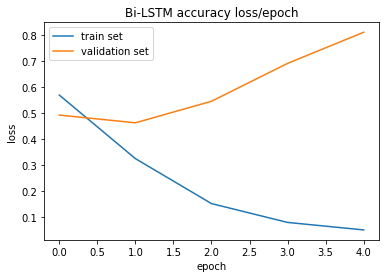

In [ ]:
# training and validation Loss function
plt.plot(historic_bilstm_1.history['loss'])
plt.plot(historic_bilstm_1.history['val_loss'])
plt.title('Bi-LSTM accuracy loss/epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train set', 'validation set'], loc='upper left')
plt.show()

5. (5 points) Affichez dans une figure la précision globale (accuracy)/ époque sur le jeu de données d’entrainement (train) et de validation (val). Voir l'énoncé pour un exemple de figure.

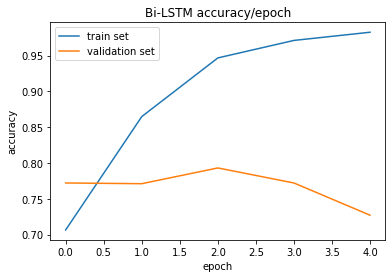

In [ ]:
# training and validation accuracy function
plt.plot(historic_bilstm_1.history['accuracy'])
plt.plot(historic_bilstm_1.history['val_accuracy'])
plt.title('Bi-LSTM accuracy/epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train set', 'validation set'], loc='upper left')
plt.show()

6. (2 points) Chargez le meilleur modèle retenu, et affichez les performances de ce meilleur modèle sur l’ensemble de test. Utilisez la métrique Accuracy. (Exemple: Accuracy: 0.82)

In [ ]:
best_model_bilstm_1 = load_model('best_model_no_emb.hdf5')
Y_test_bilstm_1 = best_model_bilstm_1.predict(x_test_tokenized)

In [ ]:
y_test_pred_bilstm = np.where(Y_test_bilstm_1.flatten() > 0.5, 1, 0)
y_test_target_bilstm = np.array(y_test)

# tabs classification metrics
print("naive bayes for unigrams and bigrams")
print(classification_report(y_test_target_bilstm, y_test_pred_bilstm))

# Confusion matrix
C_bilstm_1 = confusion_matrix(y_test_pred_bilstm, y_test_target_bilstm)
print("Confusion matrix Bi-lstm:", C_bilstm_1, sep="\n")

# Accuracy
metric = keras.metrics.Accuracy()
metric.update_state(y_test_target_bilstm,y_test_pred_bilstm)
acc_bilstm_1 = metric.result().numpy()
print("Accuracy of the Bi-LSTM :", acc_bilstm_1, sep="\n")

naive bayes for unigrams and bigrams
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1172
           1       0.73      0.71      0.72       828

    accuracy                           0.77      2000
   macro avg       0.77      0.76      0.77      2000
weighted avg       0.77      0.77      0.77      2000

Confusion matrix Bi-lstm:
[[958 239]
 [214 589]]
Accuracy of the Bi-LSTM :
0.7735




#### Bi-LSTM avec plongement GLoVe

7. (10 points) En utilisant des plongements lexicaux pré-entrainés GLOVE, implémentez un modèle Bi-LSTM à deux couches avec Keras utilisant ces plongements et avec les mêmes critères d’EarlyStopping et de ModelCheckpoint que précédemment, et entrainez-le sur l’ensemble d’entrainement. Sauvegardez votre meilleur modèle. 

##### Téléchargement de GloVe

In [21]:

import requests, zipfile, io
zip_file_url = "http://nlp.stanford.edu/data/glove.840B.300d.zip"
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

#nb_features = 20000
maxlen = 300


In [22]:

print('loading word embeddings...')


embeddings_index = {}
f = codecs.open('glove.840B.300d.txt', encoding='utf-8')

for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors' % len(embeddings_index))


loading word embeddings...


2196018it [06:29, 5636.19it/s]

found 2196016 word vectors


In [23]:
#embedding matrix
print('preparing embedding matrix...')

#max_seq_len
nb_words = 20000
#nb_words = min(nb_features, vocab_size))
embeded_dim = 300 #fixed value

words_not_found = []

embedding_matrix = np.zeros((nb_words, embeded_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))


preparing embedding matrix...
number of null word embeddings: 1248


##### Model avec GloVe

In [ ]:
# Bi-LSTM model in Keras.
def bi_lstm_glove_model(nb_words,
                        embedding_matrix,
                  lstm_units,
                  dropout_rate,
                  embeded_dim,
                  drop_bool=False): #boolean to use dropout or not
  
    # define the layers.
    inputs = keras.Input(shape=(None,), dtype="int32")

    x = layers.Embedding(nb_words, embeded_dim, weights=[embedding_matrix])(inputs)
    x = layers.Bidirectional(layers.LSTM(units=lstm_units, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(units=lstm_units))(x)
    if (drop_bool==True):
      x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
## TUNING PARAMETERS ##
#max_seq_len
#nb_words
#embeded_dim = 300 # TODO= entre 100 et 300
lstm_units = 64
dropout_rate = 0.2
drop_bool = False

model_bi_lstm_glove = bi_lstm_glove_model(nb_words,embedding_matrix,lstm_units,dropout_rate,embeded_dim,drop_bool=False)

# compile the model
model_bi_lstm_glove.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #,'AUC'
# summarize the model
print(model_bi_lstm_glove.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 300)         6000000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 128)         186880    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 6,285,825
Trainable params: 6,285,825
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#defining the checkpoint
checkpoint2 = ModelCheckpoint("best_model_glove.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
callback2 = EarlyStopping(monitor='val_loss', patience=3)

historic_bilstm_glove = model_bi_lstm_glove.fit(x_train_tokenized, y_train, batch_size=32, epochs=6, validation_data=(x_val_tokenized, y_val), callbacks=[checkpoint2,callback2])


Epoch 1/6
219/219 [==============================] - 527s 2s/step - loss: 0.5593 - accuracy: 0.7141 - val_loss: 0.4950 - val_accuracy: 0.7790

Epoch 00001: val_accuracy improved from -inf to 0.77900, saving model to best_model_glove.hdf5
Epoch 2/6
219/219 [==============================] - 518s 2s/step - loss: 0.4048 - accuracy: 0.8114 - val_loss: 0.4436 - val_accuracy: 0.7950

Epoch 00002: val_accuracy improved from 0.77900 to 0.79500, saving model to best_model_glove.hdf5
Epoch 3/6
219/219 [==============================] - 518s 2s/step - loss: 0.1973 - accuracy: 0.9216 - val_loss: 0.5436 - val_accuracy: 0.7890

Epoch 00003: val_accuracy did not improve from 0.79500
Epoch 4/6
219/219 [==============================] - 518s 2s/step - loss: 0.0854 - accuracy: 0.9687 - val_loss: 0.7117 - val_accuracy: 0.7830

Epoch 00004: val_accuracy did not improve from 0.79500
Epoch 5/6
219/219 [==============================] - 518s 2s/step - loss: 0.0481 - accuracy: 0.9823 - val_loss: 0.8054 - val_

##### Evaluation du modèle bilstm avec glove

8. (2 points) De la même manière que précédemment, affichez dans deux figures la fonction de perte et la précision globale (accuracy) / époque sur le jeu de données d’entrainement (train) et de validation (val).

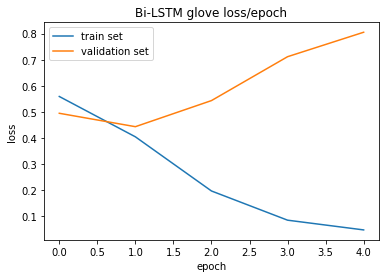

In [ ]:
# training and validation Loss function
plt.plot(historic_bilstm_glove.history['loss'])
plt.plot(historic_bilstm_glove.history['val_loss'])
plt.title('Bi-LSTM glove loss/epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train set', 'validation set'], loc='upper left')
plt.show()

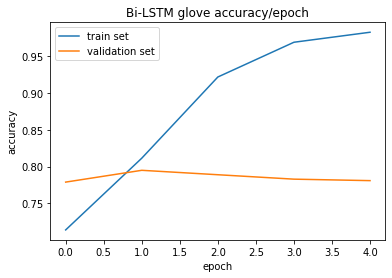

In [ ]:
# training and validation accuracy function
plt.plot(historic_bilstm_glove.history['accuracy'])
plt.plot(historic_bilstm_glove.history['val_accuracy'])
plt.title('Bi-LSTM glove accuracy/epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train set', 'validation set'], loc='upper left')
plt.show()

9. (2 points) Affichez les performances de votre meilleur modèle à base de plongements sur l’ensemble de test. Utilisez la métrique de précision globale (Accuracy).

In [ ]:
best_model_bilstm_glove = load_model('best_model_glove.hdf5')
Y_test_bilstm_glove = best_model_bilstm_glove.predict(x_test_tokenized)

y_test_pred_bilstm_glove = np.where(Y_test_bilstm_glove.flatten() > 0.5, 1, 0)
y_test_target_bilstm_glove = np.array(y_test)

# tabs classification metrics
print("classification report for bi-lstm glove on test set")
print(classification_report(y_test_target_bilstm_glove, y_test_pred_bilstm_glove))

# Confusion matrix
C_bilstm_glove = confusion_matrix(y_test_pred_bilstm_glove, y_test_target_bilstm_glove)
print("Confusion matrix Bi-lstm glove:", C_bilstm_glove, sep="\n")

# Accuracy
metric = keras.metrics.Accuracy()
metric.update_state(y_test_target_bilstm_glove,y_test_pred_bilstm_glove)
acc_bilstm_glove = metric.result().numpy()
print("Accuracy of the Bi-LSTM glove:", acc_bilstm_glove, sep="\n")

classification report for bi-lstm glove on test set
              precision    recall  f1-score   support

           0       0.78      0.90      0.83      1172
           1       0.81      0.63      0.71       828

    accuracy                           0.79      2000
   macro avg       0.79      0.76      0.77      2000
weighted avg       0.79      0.79      0.78      2000

Confusion matrix Bi-lstm glove:
[[1049  304]
 [ 123  524]]
Accuracy of the Bi-LSTM glove:
0.7865


#### Amélioration du model précédent

10. (5 points) Si ce n’est pas déjà le cas, tentez de dépasser les performances de votre meilleur modèle traditionnel en créant un nouveau modèle Bi-LSTM (vous pouvez ajouter des couches, utiliser du dropout, utiliser d’autres modèles de plongements, etc.)

Pour améliorer notre modèle, nous avons ajouter un prétraitrement, ajouter du dropout et un bilstl layer. Nous avons tester le w2vec (le code du w2vec ce trouve dans la partie annexe du ipynb) qui ne nous donnait pas de meilleurs résultats que le glove. Donc nous avons gardé le glove. Finalement, nous ajoutons 'AUC' comme metric à notre entrainement, qui est une meilleur metric pour la classification.

##### ajout de prétraitement

Conrairement aux modéles traditionnels qui utilisent le tfidf et qui donc discriment les termes récurrents, pour les modéles neuronnaux on a décidé de retirer les ponctuations pour diminuer la taille des nos vecteurs mots (qui vont etre reduits à la dimension de la séquence la plus longue). On a donc décider de retirer les ponctuations.

On a pu observer que en retirant les ponctuations on obtenait de meilleurs résultat pour le bilstm. Par contre selon nos tests, utiliser la lemmatisation accentue l'overfitting et nous génére de moins bon résultats.

In [33]:
#suppress punctuations
def rm_stowords_and_punctuation(segm_data):
  stopwords_english = stopwords.words('english')
  data_cleaned = []
  for word in segm_data:
    if (word not in stopwords_english and  
        word not in string.punctuation and
        word not in ('.','&',';',':','-',',','(', '?', '...', ')', "'")): # mots fréquents qui montre un sentiment "!",'...','?'
        data_cleaned.append(word)
  return data_cleaned

def add_preprocess(df, index):
   df['tokens_nopunct'] = df[index].apply(rm_stowords_and_punctuation)
   df['tokens_lemm'] = df['tokens_nopunct'].apply(lemmatize)
   return df

train_data = add_preprocess(train_data, 'tokens')
val_data = add_preprocess(val_data, 'tokens')
test_data = add_preprocess(test_data, 'tokens')

In [51]:
vocab_size_imp = len(set(flatten(train_data['tokens_nopunct'])))
print("Nb type:", vocab_size)
males_types = FreqDist(flatten(train_data[train_data["gender"] == "male"]['tokens_lemm']))
females_types = FreqDist(flatten(train_data[train_data["gender"] == "female"]['tokens_lemm']))
print(f"Nb type male: {len(males_types.keys())} / Nb type female: {len(females_types.keys())}")
print(f"Most frequent types for males : {most_frequent(males_types, 20)}")
print(f"Most frequent types for males : {most_frequent(females_types, 20)}")

Nb type: 54164
Nb type male: 33300 / Nb type female: 30475
Most frequent types for males : ['well', 'nbsp', 'got', 'really', 'good', 'day', 'people', 'thing', 'urllink', 'go', 'think', 'know', 'would', 'time', 'get', "'m", 'one', 'like', "n't", "'s"]
Most frequent types for males : ['well', 'nbsp', 'got', 'really', 'good', 'day', 'people', 'thing', 'urllink', 'go', 'think', 'know', 'would', 'time', 'get', "'m", 'one', 'like', "n't", "'s"]


In [35]:
#we define our train and validation set on tokens without punctuations

x_train_imp = train_data['tokens_nopunct']
x_val_imp = val_data['tokens_nopunct']
x_test_imp = test_data['tokens_nopunct']

'''
x_train_imp = train_data['tokens_lemm']
x_val_imp = val_data['tokens_lemm']
x_test_imp = test_data['tokens_lemm']
'''

nb_words_imp=min(20000,vocab_size_imp) #20% du voc
max_seq_len_imp=np.max([len(x) for x in x_train_imp])

tokenizer = Tokenizer(num_words=nb_words_imp)
tokenizer.fit_on_texts(x_train_imp)
word_index = tokenizer.word_index

x_train_tokenized_imp = corpus_tokenize(x_train_imp, tokenizer, max_seq_len_imp)
x_val_tokenized_imp = corpus_tokenize(x_val_imp, tokenizer, max_seq_len_imp)
x_test_tokenized_imp = corpus_tokenize(x_test_imp, tokenizer, max_seq_len_imp)

##### Glove

In [39]:
# Bi-LSTM model in Keras.
def bi_lstm_glove_improved_model(nb_words,
                                embedding_matrix,
                                lstm_units,
                                dropout_rate,
                                embeded_dim): #boolean to use dropout or not
  
    # define the layers.
    inputs = keras.Input(shape=(None,), dtype="int32")

    x = layers.Embedding(nb_words, embeded_dim, weights=[embedding_matrix])(inputs)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Bidirectional(layers.LSTM(units=lstm_units, return_sequences=True))(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Bidirectional(layers.LSTM(units=lstm_units))(x)
    x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [40]:
## TUNING PARAMETERS ##
lstm_units = 64
dropout_rate = 0.2

model_bi_lstm_improved_glove = bi_lstm_glove_improved_model(nb_words_imp,embedding_matrix,lstm_units,dropout_rate,embeded_dim)

# compile the model
#opt = tf.keras.optimizers.RMSprop()
#opt = keras.optimizers.Adam(learning_rate=0.01)
model_bi_lstm_improved_glove.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
# summarize the model
print(model_bi_lstm_improved_glove.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 300)         6000000   
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 300)         0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, None, 128)         186880    
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0   

In [41]:
#defining the checkpoint
checkpoint3 = ModelCheckpoint("best_model_glove_improved.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
callback3 = EarlyStopping(monitor='val_loss', patience=3)

historic_bilstm_improved_glove = model_bi_lstm_improved_glove.fit(x_train_tokenized_imp, y_train, batch_size=32, epochs=6, validation_data=(x_val_tokenized_imp, y_val), callbacks=[checkpoint3,callback3])

Epoch 1/6
219/219 [==============================] - 448s 2s/step - loss: 0.6101 - accuracy: 0.6601 - auc: 0.6950 - val_loss: 0.5541 - val_accuracy: 0.7030 - val_auc: 0.7996

Epoch 00001: val_accuracy improved from -inf to 0.70300, saving model to best_model_glove_improved.hdf5
Epoch 2/6
219/219 [==============================] - 422s 2s/step - loss: 0.4072 - accuracy: 0.8154 - auc: 0.8898 - val_loss: 0.4955 - val_accuracy: 0.7740 - val_auc: 0.8575

Epoch 00002: val_accuracy improved from 0.70300 to 0.77400, saving model to best_model_glove_improved.hdf5
Epoch 3/6
219/219 [==============================] - 421s 2s/step - loss: 0.2058 - accuracy: 0.9211 - auc: 0.9726 - val_loss: 0.6285 - val_accuracy: 0.7710 - val_auc: 0.8523

Epoch 00003: val_accuracy did not improve from 0.77400
Epoch 4/6
219/219 [==============================] - 421s 2s/step - loss: 0.1118 - accuracy: 0.9589 - auc: 0.9907 - val_loss: 0.7184 - val_accuracy: 0.7800 - val_auc: 0.8398

Epoch 00004: val_accuracy improved

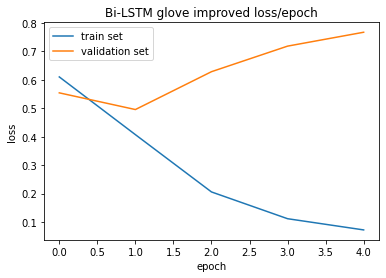

In [42]:
# training and validation Loss function
plt.plot(historic_bilstm_improved_glove.history['loss'])
plt.plot(historic_bilstm_improved_glove.history['val_loss'])
plt.title('Bi-LSTM glove improved loss/epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train set', 'validation set'], loc='upper left')
plt.show()

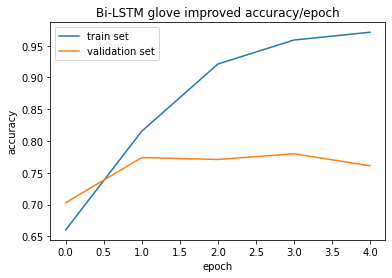

In [43]:
# training and validation accuracy function
plt.plot(historic_bilstm_improved_glove.history['accuracy'])
plt.plot(historic_bilstm_improved_glove.history['val_accuracy'])
plt.title('Bi-LSTM glove improved accuracy/epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train set', 'validation set'], loc='upper left')
plt.show()

###### evaluation

résultat du training du ipynb

In [61]:
model_bi_lstm_improved_glove = load_model('best_model_glove_improved.hdf5') 
Y_test_bilstm_glove_improved = model_bi_lstm_improved_glove.predict(x_test_tokenized_imp)

y_test_pred_bilstm_glove_imp = np.where(Y_test_bilstm_glove_improved.flatten() > 0.5, 1, 0)
y_test_target_bilstm_glove_imp = np.array(y_test)

# tabs classification metrics
print("classification report for bi-lstm glove on test set")
print(classification_report(y_test_target_bilstm_glove_imp, y_test_pred_bilstm_glove_imp))

# Confusion matrix
C_bilstm_glove_imp = confusion_matrix(y_test_pred_bilstm_glove_imp, y_test_target_bilstm_glove_imp)
print("Confusion matrix Bi-lstm glove:", C_bilstm_glove_imp, sep="\n")

# Accuracy
metric = keras.metrics.Accuracy()
metric.update_state(y_test_target_bilstm_glove_imp,y_test_pred_bilstm_glove_imp)
acc_bilstm_glove_imp = metric.result().numpy()
print("Accuracy of the Bi-LSTM glove:", acc_bilstm_glove_imp, sep="\n")

classification report for bi-lstm glove on test set
              precision    recall  f1-score   support

           0       0.77      0.88      0.82      1172
           1       0.79      0.62      0.70       828

    accuracy                           0.78      2000
   macro avg       0.78      0.75      0.76      2000
weighted avg       0.78      0.78      0.77      2000

Confusion matrix Bi-lstm glove:
[[1033  311]
 [ 139  517]]
Accuracy of the Bi-LSTM glove:
0.775


### 5.4. Évaluation (10%)

1. (4 points) Affichez une table récapitulative comparant les performances de vos différents modèles sur l’ensemble de test.

In [45]:
acc_nb = gs_clf_nb.best_score_
acc_lr = gs_clf_lr.best_score_

In [62]:
# Print the log likelihoods 
all_results = {'Naive bayes' : acc_nb,
               'logistic regression' : acc_lr,
               'BILSTM no pretrained embedding' : acc_bilstm_1,
               'GLOVE BILSTM' : acc_bilstm_glove,
               'Improved BILSTM' : acc_bilstm_glove_imp}
df = pd.DataFrame(all_results, columns = ['Naive bayes','logistic regression','BILSTM no pretrained embedding','GLOVE BILSTM','Improved BILSTM'], index=['models'])
df

,Naive bayes,logistic regression,BILSTM no pretrained embedding,GLOVE BILSTM,Improved BILSTM
models,0.813375,0.7875,0.7735,0.7865,0.775


2. (6 points) Indiquez votre conclusion dans une cellule (Meilleur algorithme? Meilleure configuration pour l’apprentissage machine «traditionnel»? Effets du GridSearch? Meilleur modèle Bi-LSTM?)

nb male: 4148	nb female: 2852	nb of data: 7000
ratio target homme/ target femme 1.4544179523141656


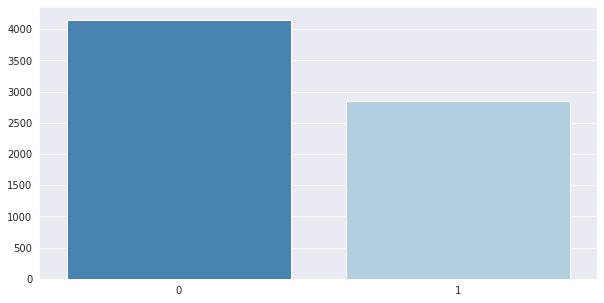

In [50]:
#plot des distributions des données
import seaborn as sns
import matplotlib.pyplot as plt

#print general data
nb_train = len(train_data)
label_0=len(train_data[train_data["gender"] == "male"])
label_1=len(train_data[train_data["gender"] == "female"])
print('nb male: {0}\tnb female: {1}\tnb of data: {2}'.format(label_0, label_1, nb_train))

# donnée complémentaire
print("ratio target homme/ target femme", label_0/label_1)

#plot class distribution
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x=[0,1],y=[label_0, label_1],palette='Blues_r',ax=ax)

Les datasets ont des distributions assez similaires à première vue. Les distributions des topics sont assez similaires même si les sujets principaux ne sont pas exactement les mêmes et les nombres de types sont à peu près équivalents. 

Pour la classification traditionnelle, on voit avec les paramètres par défaut et notre prétraitement avec tokenisation par mots, passage en minuscule et suppression des “stop words”, que les performances sont déjà assez satisfaisantes. Accuracy de 0.78 pour naive bayes et 0.80 pour la régression logistique. L’utilisation d’unigram uniquement ou d’un mélange d’unigrams et de bigrams n’influence quasiment pas les performances des deux classificateurs. 

On utilise ensuite une recherche d'hyper paramètres avec grid search et une validation croisée: 
- Pour le classificateur Naive Bayes nous avons testé 360 paramètres différents et nous avons obtenus un meilleurs score de 0.81 avec un prétraitement sans mise en minuscule, tokenization par mot, vectorisation par TFIDF pas de limite de vocabulaire, des unigrams uniquement et un paramètre alpha de 1 pour le classificateur, ce qui était déjà la valeur par défaut. Ainsi, l’amélioration est due à la non suppression des stop words et à la non mise en minuscule. 

- Pour la régression linéaire, nous avons testé 288 paramètres différents et nous avons obtenu un meilleur score de 0.79 avec encore une fois une tokenization par mot, des unigrams uniquement, pas de limite de vocabulaire, l’utilisation de TFIDF mais la mise en minuscule. Le modèle obtenu utilise une pénalité l2, ce qui est le paramètre par défaut utilisé précédemment. Contrairement au cas Naive Bayes, grid search ne nous a pas fourni un meilleur score que le modèle par défaut malgré les nombreux paramètres testés. On peut en déduire que la régression logistique est très sensible aux stop words contrairement à Naive Bayes. 

Pour la classification neuronale, nous avons d’abord testé un modèle bi-LSTM sans plongement lexicale et sans méthode de limitation du surapprentissage (sans gridsearch). Ce modèle est d’une part beaucoup plus long à entraîner que les modèles suivants mais il obtient également un score moindre de 0.77 car on observe de l’overfitting très tôt dans l'entraînement, autour de la première époque déjà.

Nous avons ensuite testé un modèle semblable mais qui utilise les vecteurs pré entraînés de GloVe. Comme ces vecteurs sont de tailles 300 alors que nous utilisions des vecteurs de taille 100 précédemment, l'entraînement est encore plus long. Mais l’accuracy augmente un peu, avec une précision de 0.79. Cette performance est équivalente à notre meilleur modèle de régression logistique et très légèrement inférieure à celle de notre meilleur Naive Bayes. Cependant on observe encore un overfitting important très tôt dans l'entraînement qui limite fortement la possibilité pour le modèle de s’améliorer.

Enfin, nous utilisons à nouveau un modèle semblable au précédent mais en ajoutant plusieurs couches de dropout pour limiter l’overfitting et espérer continuer l’entrainement plus longtemps pour améliorer l’accuracy. De plus, nous retirons les stopwords de ponctuations dans le prétraitement. Nous observons alors une accuracy de 0.82 ce qui nous fournis notre meilleur modèle jusqu’à présent. Ici sur le notebook on a toutefois obtenu 0.775, car selon les entrainements on n'a pas toujours les même résultats.

Ainsi, on a pu observé que le naive bayes performe très bien avec des stop words et obtient un score maximal de 0.81, la regression logistique elle est plus performante sans stop words et obtient jusqu’à 0.80 d’accuracy. Les méthodes neuronales sont plus longues à entraîner et demande plus de mémoire notamment lors de l’utilisation de plongements prédéfinis de grande dimension, et sont de plus très sensibles au surapprentissage. Cependant, on a réussi en ajoutant des méthodes de limitations du surapprentissage à obtenir le meilleur modèle avec une accuracy de 0.82.

Finalement il faut noter que tous les modèles ont une précision plus élevé que le recall pour la classe “femme”, et un recall plus grand que la précision pour la classe “homme”. Cela signifie que les modèles vont plus facilement classifier dans la classe “homme” que “femme”. On peut l’expliquer par le léger déséquilibre entre ces deux classes dans les données d'entraînement, environ 1.5 fois plus de données de la classe “homme”. On pourrait régler ce problème par exemple en appliquant des pénalités supplémentaires pour le fait de classifier dans la classe “homme”. En tout cas, il est important de garder en tête ce biais pour l’utilisation des ces modèles en pratique. 


### conversion en html

In [63]:
'''
%%shell
jupyter nbconvert --to html /content/TP2_lab02_05 (2).ipynb
'''

'\n%%shell\njupyter nbconvert --to html /content/TP2_lab02_05 (2).ipynb\n'

### ANNEXE : code du w2vec pour la question 10

cette annexe montre le code du w2vec, il n'a pas été tourné car ses résultats ne sont pas meilleurs.

##### definition du modéle

In [ ]:
### AVEC word2vec
def bi_lstm_word2vec_model(nb_words,
                        embedding_matrix,
                        max_seq_len,
                  lstm_units,
                  dropout_rate,
                  embeded_dim): #boolean to use dropout or not
  
    # define the layers.
    inputs = keras.Input(shape=(None,), dtype="int32")

    x = layers.Embedding(input_dim=nb_words, output_dim=embeded_dim, weights=[embedding_matrix],input_length=max_seq_len)(inputs) #,trainable=False
    x = layers.Bidirectional(layers.LSTM(units=lstm_units,return_sequences=True))(x) #,dropout=dropout_rate
    x = layers.Bidirectional(layers.LSTM(units=lstm_units))(x)
    
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
embeded_dim_w2vec=300
w2v_model = gensim.models.Word2Vec(sentences =x_train_imp, 
                                   size = embeded_dim_w2vec, 
                                   window=5,
                                   sg = 1,  # 1 for skipgram and 0 for Cbow
                                   min_count=5,
                                   workers=32)

In [ ]:
embedding_matrix_w2vec = np.zeros((nb_words_imp, embeded_dim_w2vec))

for word, token in tokenizer.word_index.items():
    if w2v_model.wv.__contains__(word):
        embedding_matrix_w2vec[token] = w2v_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix_w2vec.shape)

In [ ]:
## TUNING PARAMETERS ##
lstm_units = 64
dropout_rate = 0.3
max_seq_len_imp_=300
nb_words_imp

model_bi_lstm_improved_word2vec = bi_lstm_word2vec_model(nb_words_imp,embedding_matrix_w2vec,max_seq_len_imp, lstm_units,dropout_rate,embeded_dim_w2vec)

# compile the model
model_bi_lstm_improved_word2vec.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC'])
# summarize the model
print(model_bi_lstm_improved_word2vec.summary())

In [ ]:
#defining the checkpoint
checkpoint4 = ModelCheckpoint("best_model_word2vec.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
callback4 = EarlyStopping(monitor='val_loss', patience=3)

historic_bilstm_improved_word2vec = model_bi_lstm_improved_word2vec.fit(x_train_tokenized_imp, y_train, batch_size=32, epochs=10, validation_data=(x_val_tokenized_imp, y_val), callbacks=[checkpoint4,callback4])

##### Evaluation sur le test set

In [ ]:
# training and validation Loss function
plt.plot(historic_bilstm_improved_word2vec.history['loss'])
plt.plot(historic_bilstm_improved_word2vec.history['val_loss'])
plt.title('Bi-LSTM glove loss/epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train set', 'validation set'], loc='upper left')
plt.show()

In [ ]:
# training and validation accuracy function
plt.plot(historic_bilstm_improved_word2vec.history['accuracy'])
plt.plot(historic_bilstm_improved_word2vec.history['val_accuracy'])
plt.title('Bi-LSTM glove accuracy/epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train set', 'validation set'], loc='upper left')
plt.show()

In [ ]:
model_bi_lstm_w2vec = load_model("best_model_word2vec.hdf5")
#Y_test_bilstm_w2vec = model_bi_lstm_w2vec.predict(test_wordw2v)
Y_test_bilstm_w2vec = model_bi_lstm_w2vec.predict(x_test_tokenized_imp)

y_test_pred_bilstm_w2vec = np.where(Y_test_bilstm_w2vec.flatten() > 0.5, 1, 0)
y_test_target_bilstm_w2vec = np.array(y_test)

# tabs classification metrics
print("classification report for bi-lstm glove on test set")
print(classification_report(y_test_target_bilstm_w2vec, y_test_pred_bilstm_w2vec))

# Confusion matrix
C_bilstm_w2vec= confusion_matrix(y_test_pred_bilstm_w2vec, y_test_target_bilstm_w2vec)
print("Confusion matrix Bi-lstm glove:", C_bilstm_w2vec, sep="\n")

# Accuracy
metric = keras.metrics.Accuracy()
metric.update_state(y_test_target_bilstm_w2vec,y_test_pred_bilstm_w2vec)
acc_bilstm_w2vec = metric.result().numpy()
print("Accuracy of the Bi-LSTM glove:", acc_bilstm_w2vec, sep="\n")